# Requirements

In [27]:
import zipfile
import pandas as pd
import swifter
import os
import glob
from tqdm.auto import tqdm
from IPython.display import display

# Unzipping the dataset

In [28]:
with zipfile.ZipFile("Datasets/archive.zip", 'r') as zip_ref:
    zip_ref.extractall("Datasets")

# Reading the csv

In [29]:
tqdm.pandas()
path = os.getcwd() + "/Datasets"
csv_files = glob.glob(os.path.join(path, "*.csv"))
csv_dfs = {}
for f in csv_files:
    file_name = f.split("\\")[-1]
    
    # remove the .csv extension
    file_name = file_name[:-4]
    
    if file_name == "Amazon-Products":
        continue
    
    # read the csv file 
    df = pd.read_csv(f)
    csv_dfs[file_name] = df
    
df_all = pd.read_csv("Datasets/Amazon-Products.csv")

## Usage

In [30]:
display(csv_dfs["Amazon Fashion"])

,name,main_category,sub_category,image,link,ratings,no_of_ratings,discount_price,actual_price
0,Aqualogica Glow+ Dewy Sunscreen SPF 50 PA+++ F...,stores,Amazon Fashion,https://m.media-amazon.com/images/I/51TSC6Uogx...,https://www.amazon.in/Aqualogica-Sunscreen-Pro...,4.2,"3,628",₹351,₹399
1,MARVIK Soft Silicone Adjustable Band Strap Com...,stores,Amazon Fashion,https://m.media-amazon.com/images/I/51vYDop04S...,https://www.amazon.in/MARVIK-Silicone-Adjustab...,3.9,291,₹249,₹999
2,108 Panchatantra Stories for Children (Illustr...,stores,Amazon Fashion,https://m.media-amazon.com/images/I/81VJ+MAc7Y...,https://www.amazon.in/108-Panchatantra-Stories...,4.4,"2,950",₹125,₹160
3,Black and White and Blue: Adult Cinema From th...,stores,Amazon Fashion,https://m.media-amazon.com/images/I/51RIhaW3t1...,https://www.amazon.in/Black-White-Blue-Cinema-...,4.2,8,NaN,₹584.16
4,SAFARI 15 Ltrs Sea Blue Casual/School/College ...,stores,Amazon Fashion,https://m.media-amazon.com/images/I/61kmCas5OC...,https://www.amazon.in/SAFARI-Ltrs-Casual-Backp...,4.0,"17,985",₹299,₹799
...,...,...,...,...,...,...,...,...,...
2347,"Lakme Lip Love Gelato Lip Balm - Pink, Bubbleg...",stores,Amazon Fashion,https://m.media-amazon.com/images/I/61lc+uAfF0...,https://www.amazon.in/LAKM%C3%89-Love-Gelato-C...,4.1,515,₹148,₹199
2348,SATTVA Classy.Elegant.Stylish Classic XXXL Bea...,stores,Amazon Fashion,https://m.media-amazon.com/images/I/71zaq78pO8...,https://www.amazon.in/Sattva-Classic-Filled-Be...,4.2,10,"₹2,170","₹4,299"
2349,Fastrack Glitch Analog Rose Gold Dial Women's ...,stores,Amazon Fashion,https://m.media-amazon.com/images/I/61B+fqeyzj...,https://www.amazon.in/Fastrack-Glitch-Analog-W...,3.5,16,NaN,"₹5,595"
2350,NAINVISH Women/Girl's Pure Cotton Paisley Prin...,stores,Amazon Fashion,https://m.media-amazon.com/images/I/81qATlsYzk...,https://www.amazon.in/NAINVISH-Cotton-Paisley-...,3.4,318,₹499,"₹2,599"


---
# Preprocessing

### Amazon Fashion

In [22]:
amazon_fashion_df = csv_dfs["Amazon Fashion"]
# drop rows with missing values  # TODO: can discount be Nan?
amazon_fashion_df = amazon_fashion_df.dropna()
# drop duplicates
amazon_fashion_df = amazon_fashion_df.drop_duplicates()
# drop rows with links that are not amazon links  # TODO: check if this is necessary
amazon_fashion_df = amazon_fashion_df[amazon_fashion_df["link"].str.contains("amazon.com")]
# drop rows with links that don't work  # FIXME: how?
amazon_fashion_df = amazon_fashion_df[amazon_fashion_df["link"].str.contains("404")]
# drop columns that are not needed
amazon_fashion_df = amazon_fashion_df.drop(columns=["main_category"])
# normalize the ratings column
amazon_fashion_df["rating"] = amazon_fashion_df["rating"] / 5.0

KeyError: 'rating'

---
# Visualizing the data





In [33]:
def valid_link(link):
    from faker import Faker
    import requests
    page = requests.get(link)
    return page.status_code == 200


def increment_link_count(num_links, subject, link):
    if valid_link(link):
        num_links[subject] += 1

In [35]:
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

subjects = df_all["main_category"].unique()
num_links = {subject : 0 for subject in subjects}

df_all.progress_apply(lambda x: increment_link_count(num_links, x["main_category"], x["link"]), axis=1)

  0%|          | 0/551585 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
from urllib.request import urlopen, build_opener
# number of products plot
plot = plt.figure()
plot.set_figwidth(25)
plot.set_figheight(25)
plt.xticks(rotation=90)

for key in csv_dfs:
    number_of_products = len(csv_dfs[key])
    plt.bar(key, number_of_products, label=key)
plt.xlabel('Category', fontsize=20)
plt.ylabel('Number of products', fontsize=20)
plt.title('Number of products in each category', fontsize=20)
#make the text bigger for title


plt.show()


#now plot the normalized number of broken links by the number of products
plot_links_normalized = plt.figure()
plot_links_normalized.set_figwidth(60)
plot_links_normalized.set_figheight(25)
plt.xticks(rotation=90)
#make the text bigger for the labels
plt.tick_params(axis='x', which='major', labelsize=30)
plt.tick_params(axis='y', which='major', labelsize=20)


#more space between the labels and the plot
plt.subplots_adjust(left=0.1, right=0.7, top=0.7, bottom=0.1)
#make the gap between each two bars bigger
#pad between each label and the plot



i = 0
for key in csv_dfs:
    number_of_products = len(csv_dfs[key])
    if number_of_products == 0:
        continue
    number_of_broken_links = len(csv_dfs[key][csv_dfs[key]["link"].str.contains("404")])
    #bar each second one to make the plot more readable
    if i % 3 == 0:
        plt.bar(key, (number_of_broken_links/number_of_products)*100, label=key)
    i += 1

plt.xlabel('Category', fontsize=40)
plt.ylabel('% of broken links', fontsize=40)
plt.title('% of broken links in each category', fontsize=50)
plt.subplots_adjust(wspace=48)
plt.show()

## Reality Check

In [41]:
import text_evaluation
import imager.vgg.VGG
import numpy as np
import matplotlib.pyplot as plt
url1 = 'https://www.amazon.com/Under-Armour-Charged-Assert-X-Wide/dp/B08CFT75X3/ref=sr_1_2?_encoding=UTF8&content-id=amzn1.sym.56e14e61-447a-443b-9528-4b285fddeeac&crid=1QEZIUFPCL3YZ&dib=eyJ2IjoiMSJ9.ft2_UOW6_812lc9l1-QSVp262n9lnrp9JkYxbzch50YDBc3lzBNyzMAiBk-I0IdyUcrfaGVjLJRshNC2heUyGwkRM8s0DoTb4M6iESi81wnkVgmzqAjgcRlkbEfcDI24cTaNoVMc3Mdool0oekYx_66W7cs9xa5ygzH_QQjvrB0aNX-Mz-IKmLBuA6CGzSxzDgw_WbXkr6Xhdj7AwUuSIj9YhQVnyp4PvUZ3YtcB7qdUQcQHrIv325on_XbSy7GY5SU2aZGHOTLcpAiBLoyJGZCQLeNUz3abwIVYKtMoNGI.ThotIlFS47Lro8cttfDqEFWQr5sueLmTYX1UdYgp-yg&dib_tag=se&keywords=Shoes&pd_rd_r=20072d94-7d9c-4817-9c8a-c541f1ee3e84&pd_rd_w=iiWNK&pd_rd_wg=UgsLQ&pf_rd_p=56e14e61-447a-443b-9528-4b285fddeeac&pf_rd_r=C7WVXH61VXFF81AV2G2Y&qid=1720343515&refinements=p_36%3A-5000&rnid=2661611011&sprefix=shoes%2Caps%2C145&sr=8-2&th=1'

url2='https://www.amazon.com/dp/B0BZXMXTT2/ref=sspa_dk_detail_1?psc=1&pf_rd_p=386c274b-4bfe-4421-9052-a1a56db557ab&pf_rd_r=FND5XJ34Y17881CR2G9D&pd_rd_wg=Yvcge&pd_rd_w=cexMT&content-id=amzn1.sym.386c274b-4bfe-4421-9052-a1a56db557ab&pd_rd_r=c790c2c3-81de-4a2c-b1a0-9b79447aab15&s=shoes&sp_csd=d2lkZ2V0TmFtZT1zcF9kZXRhaWxfdGhlbWF0aWM'

url3='https://www.amazon.com/LEGO-Disney-Stitch-Building-Buildable/dp/B0CGY26D8G/ref=sr_1_2?crid=23QXV07HHVE7M&dib=eyJ2IjoiMSJ9.L1iHMZSfL_eRoYJJ69o-g2IWQlmfgJkyM2LBjhLKlvsmkzIA9Zh2e4QSKHALLuqwy1d2M_ESlzhsDcpjIh7pq_CZrm5-Zb2agU1r-sZNGxEioi8YWdvV2hBLeNCAjXJ2y91k2g08MsLNkkRiJoKTQkElGXyay7_2d-qJFGOyIz2l5lJ_QgkjW-B_i0HbcYyeOjhVguf03Rgkps7ORX4S_CXTnHCTCJHwEp__yG9gxVoNmi5M7F0I6WmVvgcswDWOD5VcZOwIuM6bgp2Wo9QO9rABEvAfiqxWOgJL7hJpTkk.7Z34_veo1afRteTuAz4oI6qG5RDHZKAyH0EXoDFmrHU&dib_tag=se&keywords=lego&qid=1721051615&sprefix=lego%2B%2Caps%2C222&sr=8-2&th=1'

#get similarity_score(url1, url2) and similarity_score(url1, url3)
similarity_score1 = text_evaluation.similarity_score(url1, url2)
similarity_score2 = text_evaluation.similarity_score(url1, url3)
print("Similarity score between url1 and url2: ", similarity_score1)
print("Similarity score between url1 and url3: ", similarity_score2)
#take images from reality check between vgg and description directory and compare them with vgg
img1 = "\\underarmor1.jpg"
img2 = "\\underarmor2.jpg"
img3 = "\\lego.jpg"
#load image
path_to_images = os.getcwd() + "\\reality_check"
img1= imager.vgg.VGG.load_image(path_to_images + img1)
img2= imager.vgg.VGG.load_image(path_to_images + img2)
img3= imager.vgg.VGG.load_image(path_to_images + img3)


#get image embeddings by vgg
vgg1 = imager.vgg.VGG.get_image_embeddings(img1)
vgg2 = imager.vgg.VGG.get_image_embeddings(img2)
vgg3 = imager.vgg.VGG.get_image_embeddings(img3)
#compare the embeddings
similarity_score3 = imager.vgg.VGG.get_score(vgg1, vgg2)
similarity_score4 = imager.vgg.VGG.get_score(vgg1, vgg3)
print("Similarity score between img1 and img2: ", similarity_score3)
print("Similarity score between img1 and img3: ", similarity_score4)









Description not found


AttributeError: 'NoneType' object has no attribute 'text'

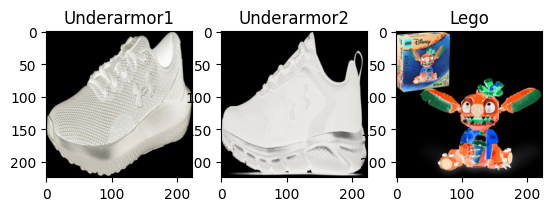

Similarity score of VGG between Underarmor1 and Underarmor2: 0.77082705
Similarity score of VGG Underarmor1 and Lego: 0.47096005

Description of Underarmor1:
  These running shoes are built to help anyone go faster-Charged Cushioning helps protect against impact, leather overlays add durable stability, and a mesh upper keeps your feet cool for miles.. Lightweight mesh upper with 3-color digital print delivers complete breathability. Durable leather overlays for stability & that locks in your midfoot. EVA sockliner provides soft, step-in comfort. Charged Cushioning midsole uses compression molded foam for ultimate responsiveness & durability. Solid rubber outsole covers high impact zones for greater durability with less weight. Offset: 10mm. NEUTRAL: For runners who need a balance of flexibility & cushioning. Lace type: Standard tie.
Description of Underarmor2: 
 These shoes are going to feel cushioned and comfortable, but also light and breathable. Why? Because when you never slow down

In [53]:
from sklearn.metrics.pairwise import cosine_similarity
import text_evaluation
img1 = "\\underarmor1.jpg"
img2 = "\\underarmor2.jpg"
img3 = "\\lego.jpg"
#load image
path_to_images = os.getcwd() + "\\reality_check"
img1= imager.vgg.VGG.load_image(path_to_images + img1)
img2= imager.vgg.VGG.load_image(path_to_images + img2)
img3= imager.vgg.VGG.load_image(path_to_images + img3)
#plot the images
fig, ax = plt.subplots(1, 3)
#size of the plot
#the colors are inverted because of the way matplotlib reads the images
#invert the colors
img1 = np.invert(img1)
img2 = np.invert(img2)
img3 = np.invert(img3)
ax[0].imshow(img1)
ax[0].set_title("Underarmor1")
ax[1].imshow(img2)
ax[1].set_title("Underarmor2")
ax[2].imshow(img3)
ax[2].set_title("Lego")
plt.show()
print("Similarity score of VGG between Underarmor1 and Underarmor2: 0.77082705")
print ("Similarity score of VGG Underarmor1 and Lego: 0.47096005\n")
##Similarity score between img1 and img2:  [[0.77082705]]
#Similarity score between img1 and img3:  [[0.47096005]]
#plot the similarities

description1 = "These running shoes are built to help anyone go faster-Charged Cushioning helps protect against impact, leather overlays add durable stability, and a mesh upper keeps your feet cool for miles.. Lightweight mesh upper with 3-color digital print delivers complete breathability. Durable leather overlays for stability & that locks in your midfoot. EVA sockliner provides soft, step-in comfort. Charged Cushioning midsole uses compression molded foam for ultimate responsiveness & durability. Solid rubber outsole covers high impact zones for greater durability with less weight. Offset: 10mm. NEUTRAL: For runners who need a balance of flexibility & cushioning. Lace type: Standard tie."
description2="These shoes are going to feel cushioned and comfortable, but also light and breathable. Why? Because when you never slow down, that's what you need. Breathable mesh upper with synthetic overlays for added structure & support. Enhanced cushioning around ankle collar for superior comfort. Deluxe Comfort System sockliner molds to your foot for ultimate step-in comfort. Charged Cushioning midsole provides all day comfort with responsiveness & durability. Durable rubber outsole provides traction & durability with flexibility where you need it for toe-off. Offset: 8mm. Weight: 10.05 oz. Lace type: Standard tie. NEUTRAL: For runners who need a balance of flexibility & cushioning."

description3="Appeal to older kids and Lilo and Stitch fans ages 9 and up with this LEGO Disney Stitch (43249) buildable play and display set, featuring a Stitch toy character. The incorrigible extraterrestrial from the hit Disney movie, dressed in a Hawaiian shirt, has movable ears and a turning head, a buildable ice cream cone that the character can hold and a buildable flower that can be added or removed. This Disney toy for 9 year old kids looks great on display in any room and makes a fun Disney gift idea for older children and movie lovers as they set up the buildable character. Kids and grown-up fans alike will appreciate the details in this building toy that lets them build and play with the iconic character together. Kids also enjoy an easy and intuitive building adventure with the LEGO Builder app, where they can zoom in and rotate models in 3D, save sets and track their progress. Contains 730 pieces."
#print the descriptions
print("Description of Underarmor1:\n ", description1)
print("Description of Underarmor2: \n", description2)
print("Description of Lego: \n", description3,"\n")
#print the similarity scores
#Similarity score between url1 and url2:  [[0.9773201]]
#Similarity score between url1 and url3:  [[0.7952991]]
#print the similarity
print ("Similarity score of the descriptions between Underarmor1 and Underarmor2: ",cosine_similarity(text_evaluation.text_embedding(description1), text_evaluation.text_embedding(description2)))
print("Similarity score of the descriptions between Underarmor1 and Lego: ",cosine_similarity(text_evaluation.text_embedding(description1), text_evaluation.text_embedding(description3)),"\n")
#print the jaccard similarity between the descriptions
jaccard_similarity = text_evaluation.jaccard_similarity(description1, description2)
jaccard_similarity2 = text_evaluation.jaccard_similarity(description1, description3)
print("Jaccard similarity between Underarmor1 and Underarmor2: ", jaccard_similarity)
print("Jaccard similarity between Underarmor1 and Lego: ", jaccard_similarity2)



---
# Hypothesis Testing - Text and Image Similarity

## Pick Samples

In [44]:
samples = 10

### Read CSV

In [51]:
path = os.getcwd() + "/Datasets"
all_df = pd.read_csv(path + "/Amazon-Products.csv")

### Get Samples

In [52]:
df = all_df.sample(n=samples)
display(df)

,Unnamed: 0,name,main_category,sub_category,image,link,ratings,no_of_ratings,discount_price,actual_price
92308,7132,crocs Unisex Baya Cerulean Blue Clogs and Mules,men's shoes,Casual Shoes,https://m.media-amazon.com/images/I/61770zxJOe...,https://www.amazon.in/crocs-Unisex-Baya-Espres...,4.1,"4,135",NaN,NaN
60616,256,Boltove® 6x9 Ft. Black Screen Backdrop Backgro...,"tv, audio & cameras",Camera Accessories,https://m.media-amazon.com/images/I/41YD3il5e0...,https://www.amazon.in/Background-Photography-P...,4.1,23,₹349,₹699
334799,272,"Bubblegummers Boys Mila Sandal Sandals, Blue, 12",kids' fashion,Kids' Shoes,https://m.media-amazon.com/images/I/51N4sczzKg...,https://www.amazon.in/Bubblegummers-Boys-MILA-...,NaN,NaN,₹524,₹699
136243,5923,KIPEK Women's Self Design Cotton Three-Quarter...,women's clothing,Ethnic Wear,https://m.media-amazon.com/images/I/61VVtpQoCi...,https://www.amazon.in/KIPEK-Three-Quarter-Desi...,3.8,34,₹559,"₹1,299"
460875,12636,LANCER Men's Sports & Outdoor Lace Up Running ...,men's shoes,Sports Shoes,https://m.media-amazon.com/images/I/71opKpsQsX...,https://www.amazon.in/Lancer-DRAGON-22BLK-GRY-...,2.8,8,"₹1,099","₹1,499"
290949,486,Truvic Pack of 3) Multipurpose Plastic Mini Du...,industrial supplies,Janitorial & Sanitation Supplies,https://m.media-amazon.com/images/I/51iq4FtPIf...,https://www.amazon.in/Truvic-Multipurpose-Plas...,4.0,2,₹193,₹376
330481,754,Fusefit Girl's Hybrid Shorts Regular Spandex,kids' fashion,Kids' Clothing,https://m.media-amazon.com/images/I/81RP1BUi2u...,https://www.amazon.in/Fusefit-Girls-Hybrid-Sho...,3.2,5,NaN,NaN
398045,38,Haier 175 L 2 Star Single Door Refrigerator (H...,appliances,Refrigerators,https://m.media-amazon.com/images/I/718NPwPMm4...,https://www.amazon.in/Haier-Single-Refrigerato...,4.0,11,"₹12,490","₹16,490"
239495,6411,Aroma® NB119 Champion Bluetooth Wireless Heads...,"tv, audio & cameras",Headphones,https://m.media-amazon.com/images/I/61fFc05J-p...,https://www.amazon.in/NB119-Champion-Bluetooth...,3.6,26,₹564,"₹2,999"
23307,3,beatXP Kitchen Scale Multipurpose Portable Ele...,home & kitchen,All Home & Kitchen,https://m.media-amazon.com/images/I/61Is7sICRJ...,https://www.amazon.in/beatXP-Multipurpose-Port...,3.7,"3,306",₹399,"₹1,999"


### Text Similarity

In [53]:
import importlib
imported_module = importlib.import_module("text_evaluation")
importlib.reload(imported_module)
import text_evaluation
import numpy as np

urls = df["link"].to_list()
# text sims as a list of lists
text_sims = np.array([[text_evaluation.similarity_score(urls[i], urls[j]).item()  for i in range(samples)] for j in range(samples)])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sean\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sean\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Get Embeddings

In [54]:
from imager.image_classifier import embed_image_from_url
image_urls = df["image"].to_list()
embeddings = [embed_image_from_url(image_urls[i]) for i in range(samples)]

### Image Similarity

In [55]:
from imager.vgg.VGG import get_score
import numpy as np
# image sims as a list of lists
image_sims = np.array([[get_score(embeddings[i], embeddings[j]).item() for i in range(samples)] for j in range(samples)])

# Similairties Matrix

In [56]:
import pandas as pd
# add column names to the dataframe
text_df = pd.DataFrame(text_sims)
image_df = pd.DataFrame(image_sims)
# get all the index i s.t i,i = 0 in image_df
ind = [i for i in range(samples) if image_df.iloc[i,i] == 0]
# remove the rows and columns with index i
text_df = text_df.drop(ind)
text_df = text_df.drop(columns=ind)
image_df = image_df.drop(ind)
image_df = image_df.drop(columns=ind)

### Heatmap

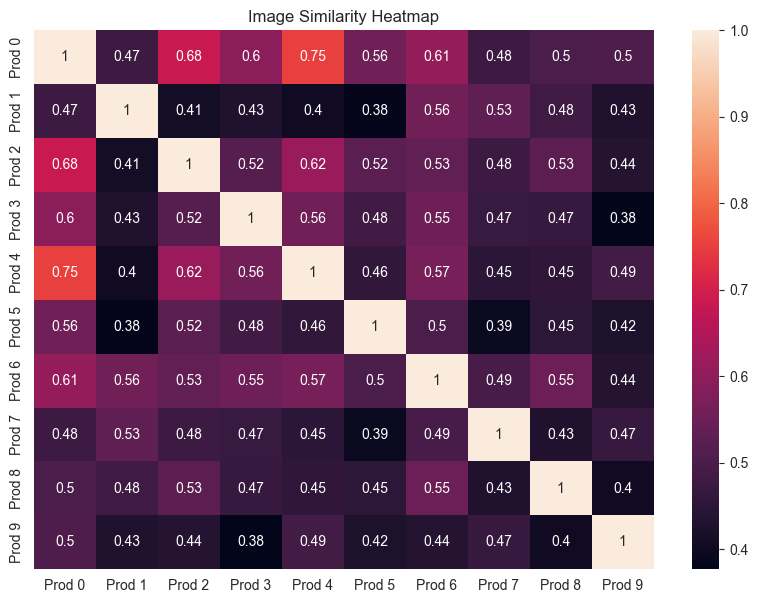

In [57]:
sims = pd.DataFrame(image_df)

# x * text_sim + 1-x * image_sim

avg_val = sims.to_numpy().mean()
# Text Similarity heatmap
import seaborn as sns
import matplotlib.pyplot as plt
mask = np.triu(np.ones_like(sims, dtype=bool))
plt.figure(figsize=(10, 7))
# sns.heatmap(sims, annot=True, mask=mask)
sns.heatmap(sims, annot=True, xticklabels=[f"Prod {i}" for i in range(len(sims))], yticklabels=[f"Prod {i}" for i in range(len(sims))])

# add title
plt.title("Image Similarity Heatmap")

plt.show()

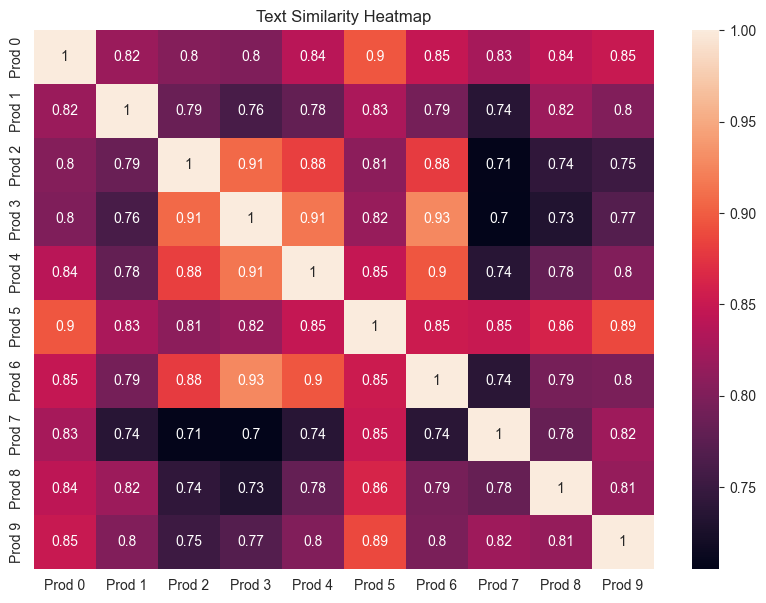

In [58]:
sims = pd.DataFrame(text_df)

# x * text_sim + 1-x * image_sim

avg_val = sims.to_numpy().mean()
# Text Similarity heatmap
import seaborn as sns
import matplotlib.pyplot as plt
mask = np.triu(np.ones_like(sims, dtype=bool))
plt.figure(figsize=(10, 7))
# sns.heatmap(sims, annot=True, mask=mask)
sns.heatmap(sims, annot=True, xticklabels=[f"Prod {i}" for i in range(len(sims))], yticklabels=[f"Prod {i}" for i in range(len(sims))])

# add title
plt.title("Text Similarity Heatmap")

plt.show()

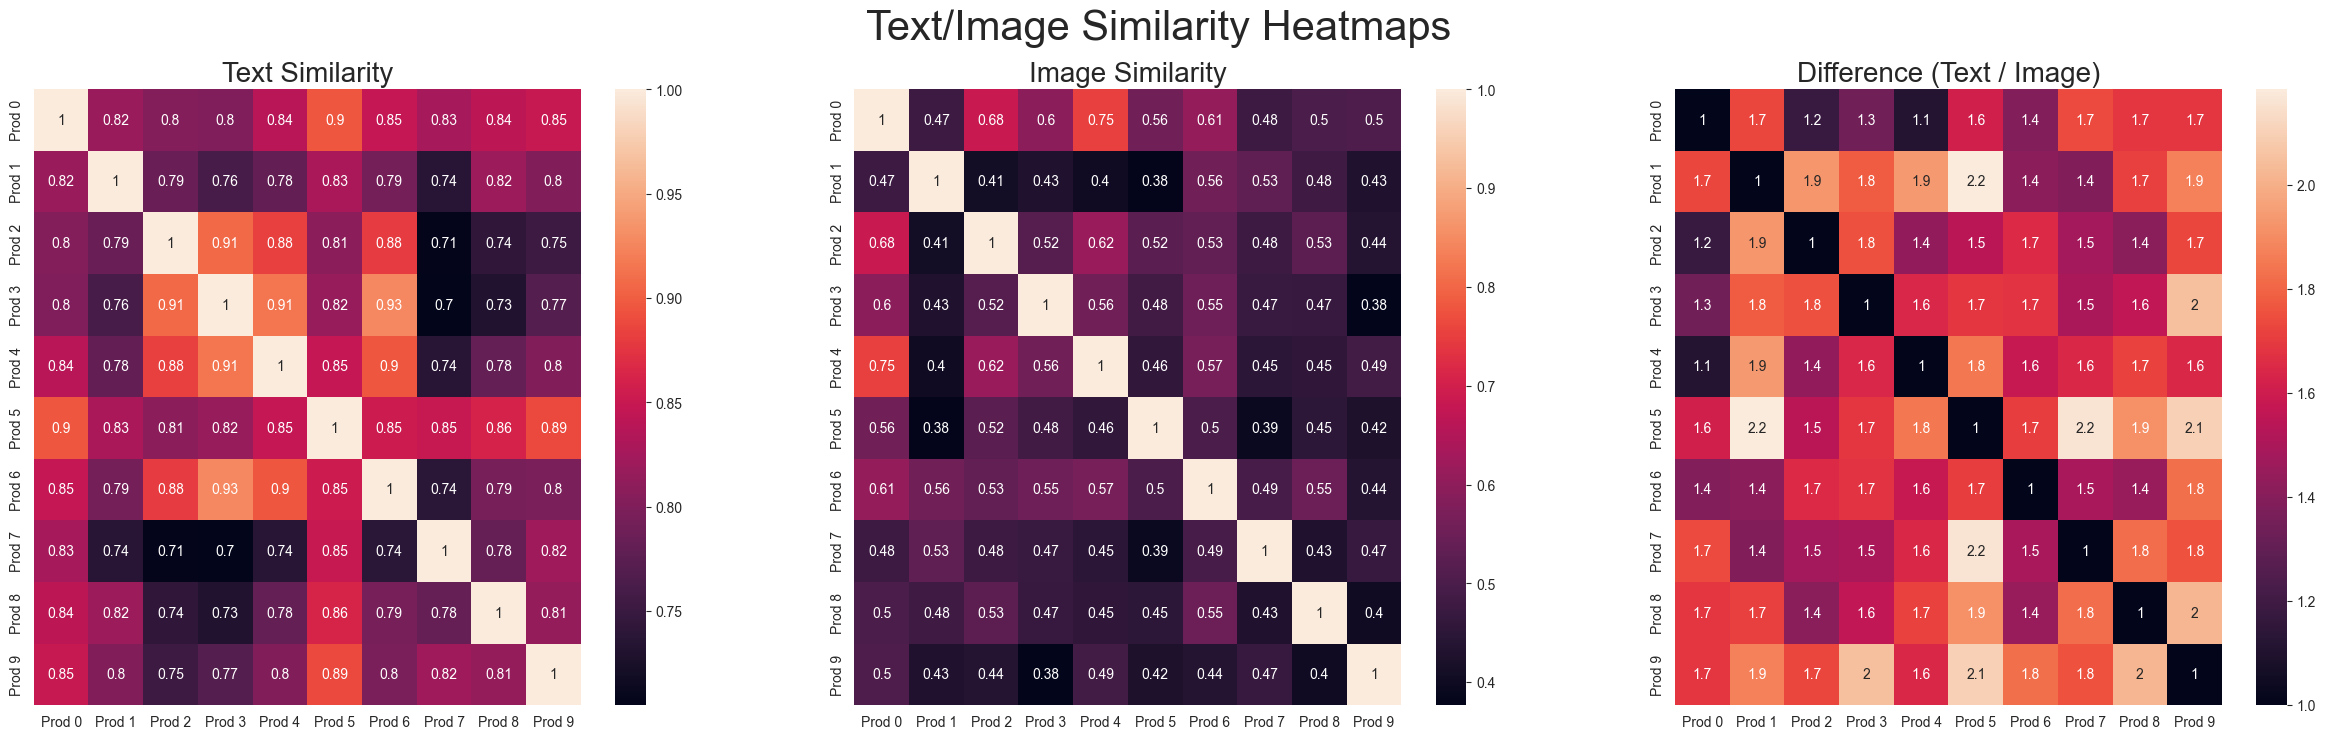

In [59]:
# make the heatmaps of the text and image similarities, and the difference between them as subplots
fig, axs = plt.subplots(1, 3, figsize=(30, 8))
# Text Similarity heatmap
sns.heatmap(text_df, annot=True, ax=axs[0], xticklabels=[f"Prod {i}" for i in range(len(sims))], yticklabels=[f"Prod {i}" for i in range(len(sims))])
axs[0].set_title("Text Similarity", fontsize=20)
# Image Similarity heatmap
sns.heatmap(image_df, annot=True, ax=axs[1], xticklabels=[f"Prod {i}" for i in range(len(sims))], yticklabels=[f"Prod {i}" for i in range(len(sims))])
axs[1].set_title("Image Similarity", fontsize=20)
# Difference heatmap
sns.heatmap(text_df / image_df, annot=True, ax=axs[2], xticklabels=[f"Prod {i}" for i in range(len(sims))], yticklabels=[f"Prod {i}" for i in range(len(sims))])
axs[2].set_title("Difference (Text / Image)", fontsize=20)
# add title
plt.suptitle("Text/Image Similarity Heatmaps", fontsize=30)
plt.show()

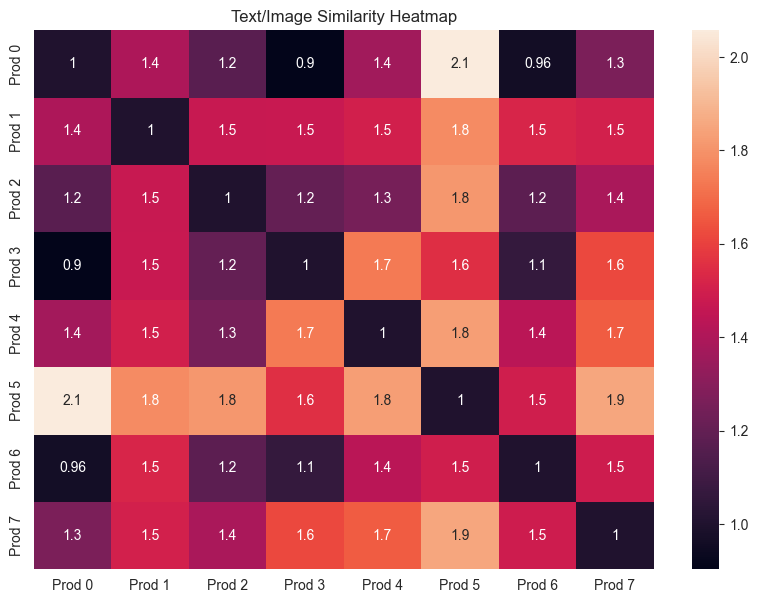

In [35]:
sims = pd.DataFrame(np.abs(text_df / image_df))

# x * text_sim + 1-x * image_sim

avg_val = sims.to_numpy().mean()
# Text Similarity heatmap
import seaborn as sns
import matplotlib.pyplot as plt
mask = np.triu(np.ones_like(sims, dtype=bool))
plt.figure(figsize=(10, 7))
# sns.heatmap(sims, annot=True, mask=mask)
sns.heatmap(sims, annot=True, xticklabels=[f"Prod {i}" for i in range(len(sims))], yticklabels=[f"Prod {i}" for i in range(len(sims))])

# add title
plt.title("Text/Image Similarity Heatmap")

plt.show()

# Heatmap with average value

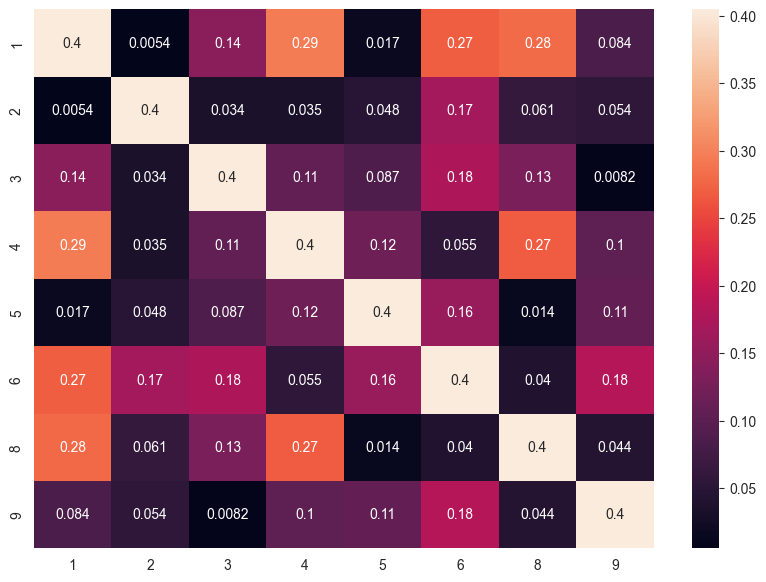

In [12]:
image_df2 = image_df * avg_val
sims2 = pd.DataFrame(np.abs(text_df - image_df2))
# mask = np.triu(np.ones_like(sims2, dtype=bool))
plt.figure(figsize=(10, 7))
# sns.heatmap(sims2, annot=True, mask=mask)
sns.heatmap(sims2, annot=True)
plt.show()

---
## Exploration

In [14]:
x = 1

KeyboardInterrupt: 